# Airbnb Rating Predictor

In [23]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb

Data Loading

In [24]:
airbnb_filename = "airbnbListingsData.csv"
df = pd.read_csv(airbnb_filename)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns}")

Dataset shape: (28022, 50)
Columns: Index(['name', 'description', 'neighborhood_overview', 'host_name',
       'host_location', 'host_about', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_group_cleansed', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'review_scores_rating', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scor

Exploratory Data Analysis

In [25]:
print(f"Shape: {df.shape}")
print(f"Data types:\n{df.dtypes}")

Shape: (28022, 50)
Data types:
name                                             object
description                                      object
neighborhood_overview                            object
host_name                                        object
host_location                                    object
host_about                                       object
host_response_rate                              float64
host_acceptance_rate                            float64
host_is_superhost                                  bool
host_listings_count                             float64
host_total_listings_count                       float64
host_has_profile_pic                               bool
host_identity_verified                             bool
neighbourhood_group_cleansed                     object
room_type                                        object
accommodates                                      int64
bathrooms                                       float64
bedrooms         

In [26]:
print(f"Missing values:")
for col in df.columns:
  if df[col].isnull().sum() > 0:
    print(f"{col}: {df[col].isnull().sum()}")

Missing values:
name: 5
description: 570
neighborhood_overview: 9816
host_location: 60
host_about: 10945
host_response_rate: 11843
host_acceptance_rate: 11113
bedrooms: 2918
beds: 1354


In [27]:
#Target Variable Analysis
missing_targets = df['review_scores_rating'].isnull().sum()
print(f"Target variable missing values: {missing_targets}")

if missing_targets > 0:
  print(f"Removing {missing_targets} rows with missing target values")
  df = df.dropna(subset=['review_scores_rating'])
  print(f"Dataset shape after cleaning: {df.shape}")

print(f"Target variable statistics:\n{df['review_scores_rating'].describe()}")
print(f"Target variable distribution:\n{df['review_scores_rating'].value_counts().head(10)}")

Target variable missing values: 0
Target variable statistics:
count    28022.000000
mean         4.683482
std          0.505857
min          0.000000
25%          4.600000
50%          4.830000
75%          5.000000
max          5.000000
Name: review_scores_rating, dtype: float64
Target variable distribution:
review_scores_rating
5.00    8674
4.00    1180
4.50    1100
4.67     899
4.75     725
4.80     610
4.83     585
4.88     518
4.86     480
4.89     436
Name: count, dtype: int64


In [28]:
for col in df.columns:
  print(f"{col} has {df[col].nunique()} unique values")

name has 27386 unique values
description has 25952 unique values
neighborhood_overview has 15800 unique values
host_name has 7566 unique values
host_location has 1364 unique values
host_about has 11962 unique values
host_response_rate has 85 unique values
host_acceptance_rate has 101 unique values
host_is_superhost has 1 unique values
host_listings_count has 73 unique values
host_total_listings_count has 73 unique values
host_has_profile_pic has 1 unique values
host_identity_verified has 1 unique values
neighbourhood_group_cleansed has 5 unique values
room_type has 4 unique values
accommodates has 16 unique values
bathrooms has 16 unique values
bedrooms has 11 unique values
beds has 16 unique values
amenities has 25020 unique values
price has 684 unique values
minimum_nights has 95 unique values
maximum_nights has 229 unique values
minimum_minimum_nights has 98 unique values
maximum_minimum_nights has 102 unique values
minimum_maximum_nights has 206 unique values
maximum_maximum_nights

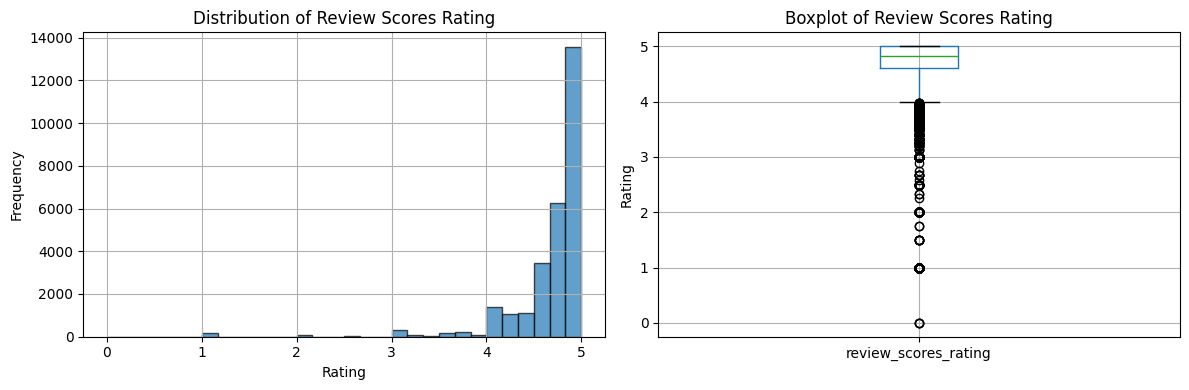

In [29]:
#Visualize Target Distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
df['review_scores_rating'].hist(bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Review Scores Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df.boxplot(column='review_scores_rating')
plt.title('Boxplot of Review Scores Rating')
plt.ylabel('Rating')
plt.tight_layout()
plt.show()

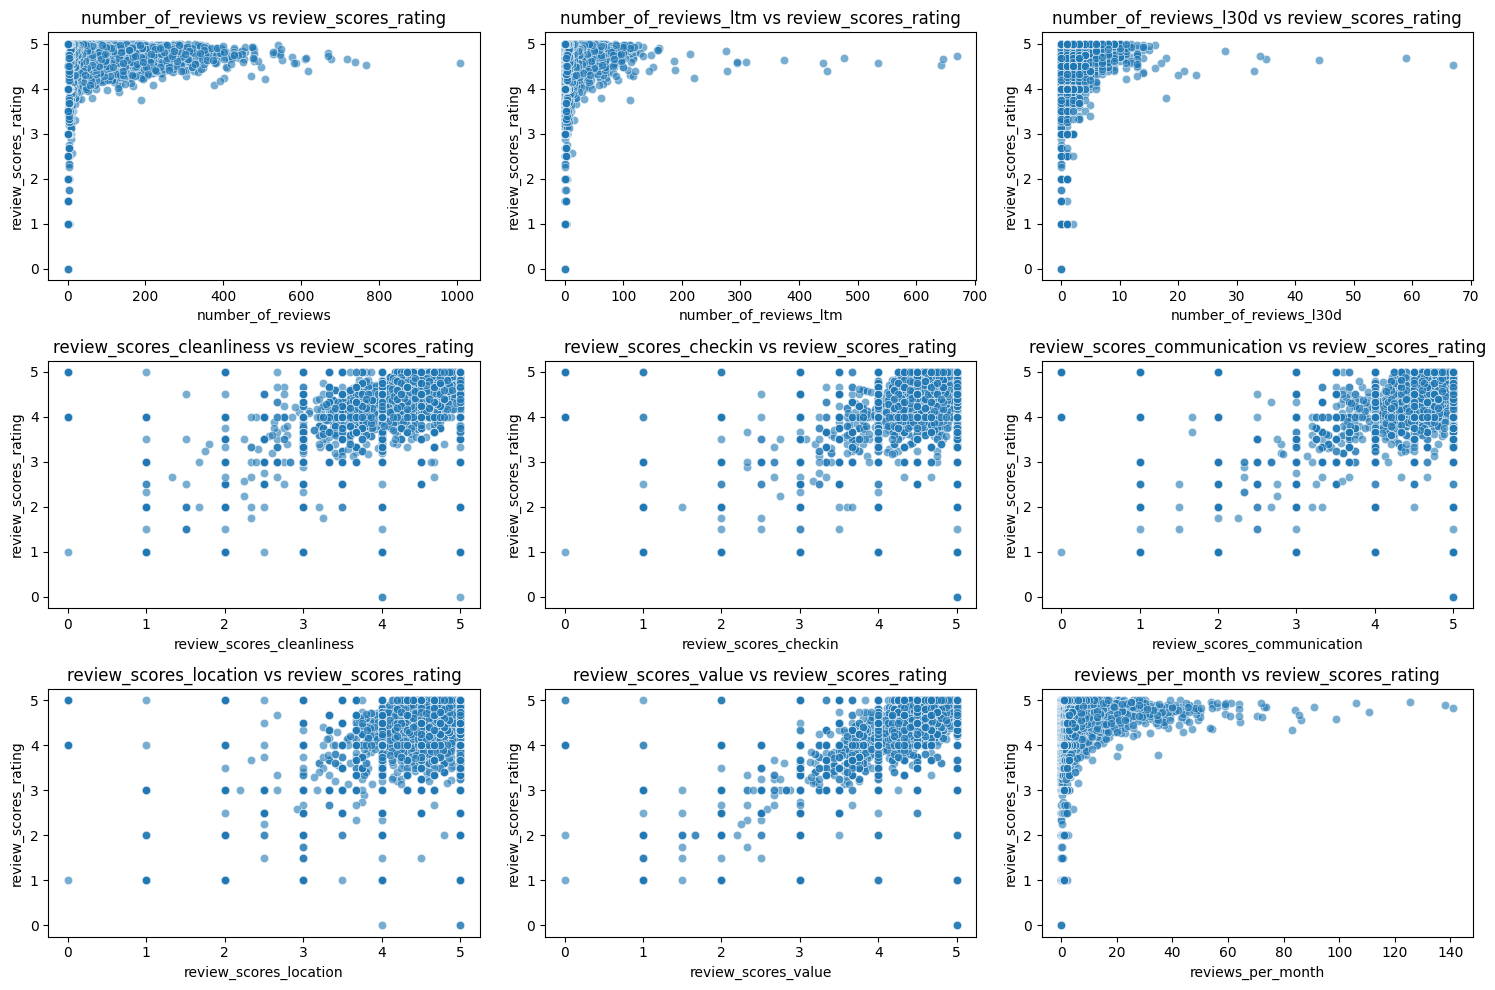

In [30]:
# Numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns
review_score_cols = [col for col in numeric_cols if ('review_scores_' in col or 'reviews' in col) and col != 'review_scores_rating']

if len(review_score_cols) > 0:
    plt.figure(figsize=(15, 10))
    n_cols = 3
    n_rows = (len(review_score_cols) + n_cols - 1) // n_cols

    for i, col in enumerate(review_score_cols, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.scatterplot(data=df, x=col, y='review_scores_rating', alpha=0.6)
        plt.title(f'{col} vs review_scores_rating')

    plt.tight_layout()
    plt.show()


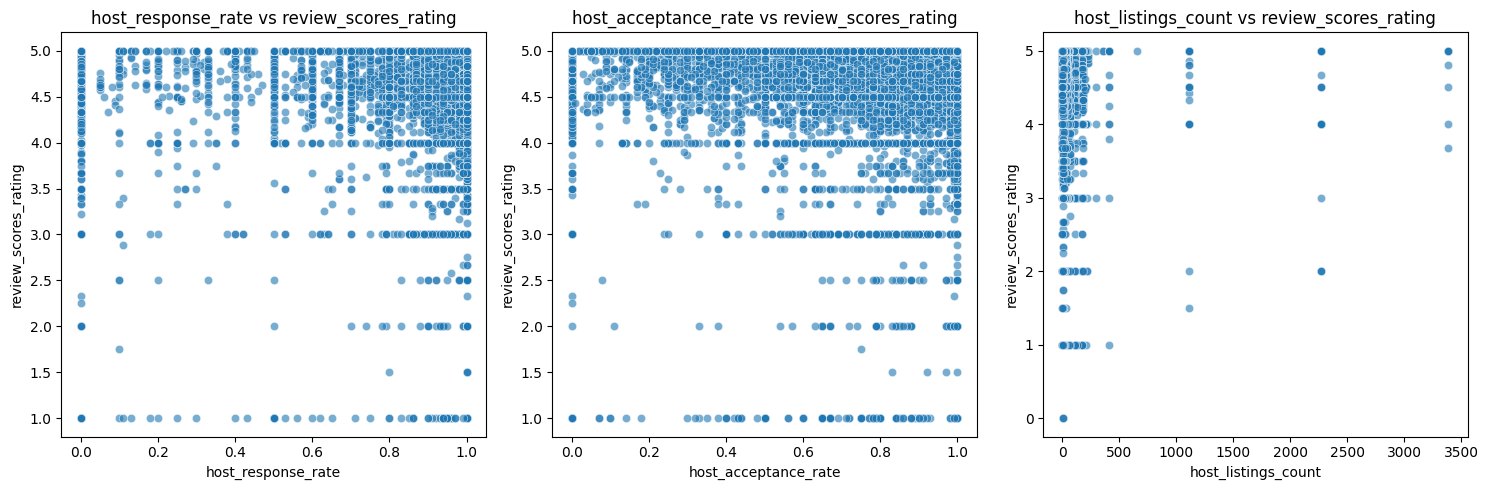

In [31]:
# Host-related features correlation analysis
host_cols = [col for col in df.columns if 'host_' in col and df[col].dtype in ['int64', 'float64']]
if len(host_cols) > 0:
    plt.figure(figsize=(15, 5))
    for i, col in enumerate(host_cols[:3], 1):
        plt.subplot(1, 3, i)
        sns.scatterplot(data=df, x=col, y='review_scores_rating', alpha=0.6)
        plt.title(f'{col} vs review_scores_rating')
    plt.tight_layout()
    plt.show()

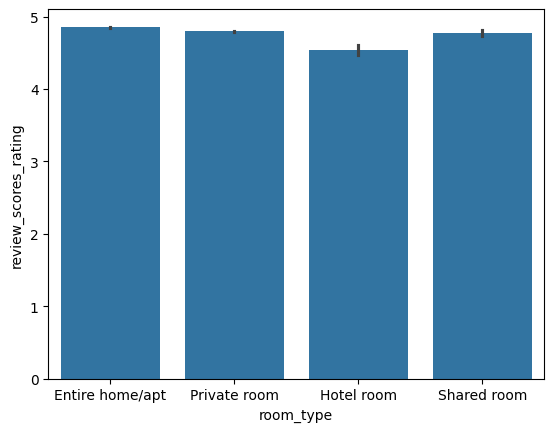

In [32]:
sns.barplot(x='room_type', y='review_scores_rating', data=df, estimator='median')
plt.show()

Data Preprocessing

In [33]:
# Identify columns with missing values
missing_counts = df.isnull().sum()
missing_cols = missing_counts[missing_counts > 0]
print(f"Columns with missing values:\n{missing_cols}")

Columns with missing values:
name                         5
description                570
neighborhood_overview     9816
host_location               60
host_about               10945
host_response_rate       11843
host_acceptance_rate     11113
bedrooms                  2918
beds                      1354
dtype: int64


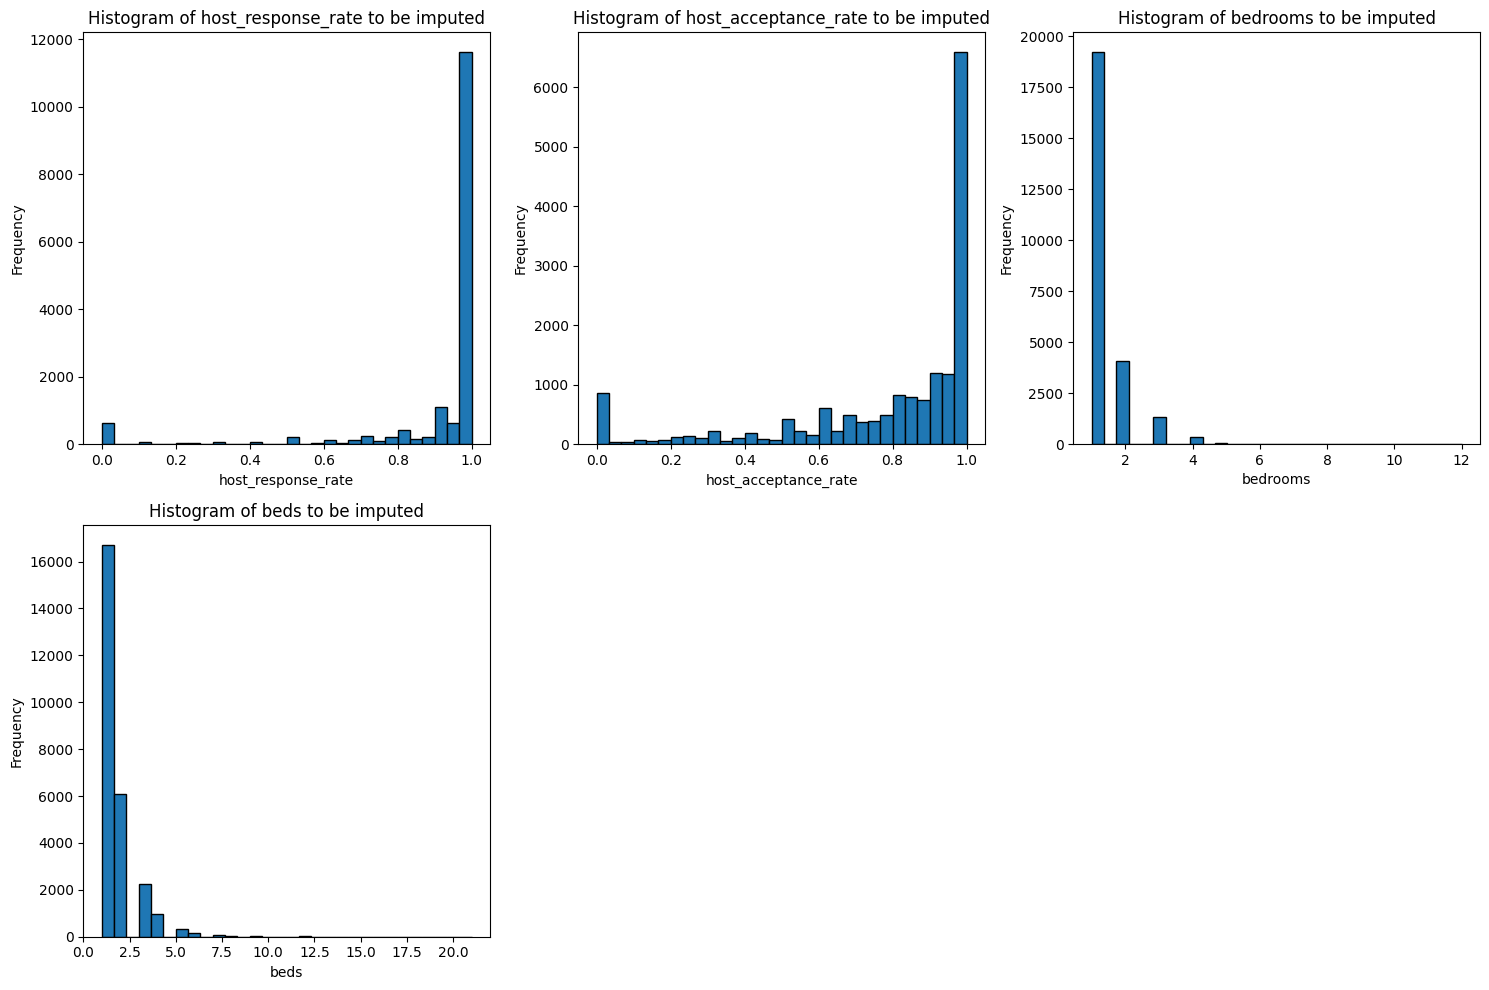

In [34]:
# Handle numeric columns
is_numeric = (df.dtypes == 'int64')|(df.dtypes == 'float64')
has_missing = df.isnull().sum() > 0
numeric_cols = df.columns[is_numeric & has_missing]

plt.figure(figsize=(15, 10))
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

for i, col in enumerate(numeric_cols, 1):
  plt.subplot(n_rows, n_cols, i)
  df[col].hist(bins=30, edgecolor='black')
  plt.title(f'Histogram of {col} to be imputed')
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.grid(False)
plt.tight_layout()
plt.show()

for col in numeric_cols:
  df[f'{col}_na'] = df[col].isnull().astype(int)
  df[col] = df[col].fillna(df[col].median())

In [35]:
# Calculate missing rate for text columns
text_cols = df.columns[df.dtypes == 'object']
text_missing_rate = (df[text_cols].isnull().sum() / len(df)).sort_values(ascending=False)
print("Missing rate for text columns:")
print(text_missing_rate)

# Drop text columns with high missing rates
high_missing_text_cols = text_missing_rate[text_missing_rate > 0].index
print(f"\nDropping text columns with missing values: {high_missing_text_cols}")
df.drop(columns=high_missing_text_cols, inplace=True)

Missing rate for text columns:
host_about                      0.390586
neighborhood_overview           0.350296
description                     0.020341
host_location                   0.002141
name                            0.000178
host_name                       0.000000
neighbourhood_group_cleansed    0.000000
room_type                       0.000000
amenities                       0.000000
dtype: float64

Dropping text columns with missing values: Index(['host_about', 'neighborhood_overview', 'description', 'host_location',
       'name'],
      dtype='object')


In [36]:
#Feature Engineering
cols_to_drop = []
for col in df.columns:
  if df[col].nunique() == 1:
    cols_to_drop.append(col)
    print(f"Dropping {col}: only one unique value")
  elif df[col].dtype == 'object' and df[col].nunique() > 10:
    cols_to_drop.append(col)
    print(f"Dropping {col}: too many categories ({df[col].nunique()})")
df.drop(cols_to_drop, axis=1, inplace=True)
categorical_cols = df.columns[df.dtypes == 'object']
df_encoded = pd.get_dummies(df, columns=categorical_cols, prefix=categorical_cols)
print(f"One-hot encoded columns: {list(categorical_cols)}")

# Convert boolean to numeric
bool_cols = df_encoded.columns[df_encoded.dtypes == 'bool']
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)
print(f"Converted boolean columns to numeric: {bool_cols}")

Dropping host_name: too many categories (7566)
Dropping host_is_superhost: only one unique value
Dropping host_has_profile_pic: only one unique value
Dropping host_identity_verified: only one unique value
Dropping amenities: too many categories (25020)
One-hot encoded columns: ['neighbourhood_group_cleansed', 'room_type']
Converted boolean columns to numeric: Index(['has_availability', 'instant_bookable',
       'neighbourhood_group_cleansed_Bronx',
       'neighbourhood_group_cleansed_Brooklyn',
       'neighbourhood_group_cleansed_Manhattan',
       'neighbourhood_group_cleansed_Queens',
       'neighbourhood_group_cleansed_Staten Island',
       'room_type_Entire home/apt', 'room_type_Hotel room',
       'room_type_Private room', 'room_type_Shared room'],
      dtype='object')


In [37]:
#Correlation Analysis
correlations = df_encoded.corr()['review_scores_rating'].sort_values(ascending=False)
print("Top 15 features correlated with target:")
print(correlations.head(15))

Top 15 features correlated with target:
review_scores_rating                     1.000000
review_scores_value                      0.820631
review_scores_cleanliness                0.758213
review_scores_communication              0.727749
review_scores_checkin                    0.688152
review_scores_location                   0.574464
room_type_Entire home/apt                0.096000
host_response_rate                       0.092193
number_of_reviews_l30d                   0.067435
number_of_reviews                        0.067182
neighbourhood_group_cleansed_Brooklyn    0.051198
n_host_verifications                     0.050888
number_of_reviews_ltm                    0.045595
price                                    0.045067
reviews_per_month                        0.039317
Name: review_scores_rating, dtype: float64


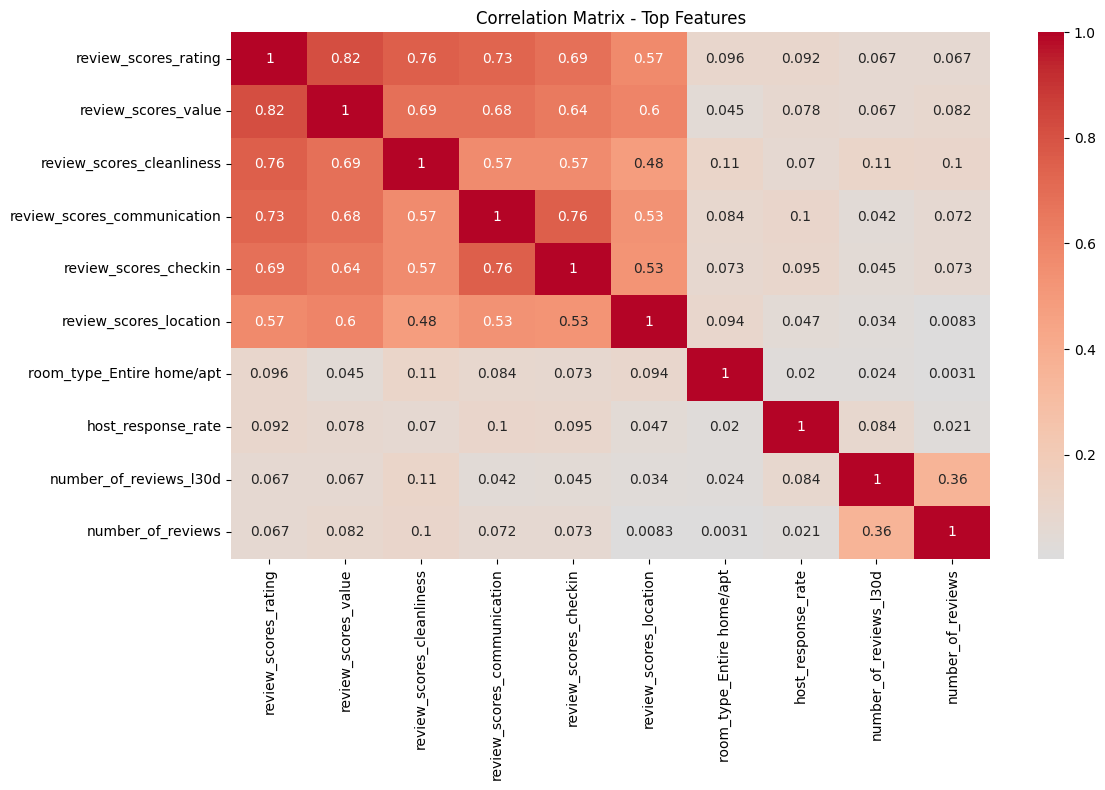

In [38]:
# Visualize correlation matrix for top features
top_features = correlations.head(10).index
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded[top_features].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Top Features')
plt.tight_layout()
plt.show()

Modeling

In [39]:
X = df_encoded.drop('review_scores_rating', axis=1)
y = df_encoded['review_scores_rating']
print(f"Final feature set shape: {X.shape}")
print(f"Final target shape: {y.shape}")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42
)

Final feature set shape: (28022, 50)
Final target shape: (28022,)


In [40]:
y_mean_pred = np.full(len(y_test), y_train.mean())
baseline_r2 = r2_score(y_test, y_mean_pred)
print(f"Mean baseline R²: {baseline_r2:.4f}")

Mean baseline R²: -0.0000


In [41]:
def eval_model(name, y_true, y_pred):
  mae = mean_absolute_error(y_true, y_pred)
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  r2 = r2_score(y_true, y_pred)

  print(f"{name} Performance:")
  print(f"  MAE: {mae:.4f}")
  print(f"  RMSE: {rmse:.4f}")
  print(f"  R²: {r2:.4f}")

  return {'MAE': mae, 'RMSE': rmse, 'R2': r2}

In [42]:
results = {}

# 1. Linear Regression
lr_model = LinearRegression()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
results['Linear Regression'] = eval_model('Linear Regression', y_test, lr_pred)

Linear Regression Performance:
  MAE: 0.1259
  RMSE: 0.2581
  R²: 0.7378


In [43]:
# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
results['Random Forest'] = eval_model('Random Forest', y_test, rf_pred)

# Feature importance for Random Forest
rf_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances (Random Forest):")
print(rf_feature_importance.head(10))


Random Forest Performance:
  MAE: 0.1226
  RMSE: 0.2289
  R²: 0.7937

Top 10 Feature Importances (Random Forest):
                        feature  importance
29          review_scores_value    0.656142
25    review_scores_cleanliness    0.101824
27  review_scores_communication    0.048758
26        review_scores_checkin    0.025903
8                         price    0.019523
35            reviews_per_month    0.016150
28       review_scores_location    0.012116
36         n_host_verifications    0.012070
22            number_of_reviews    0.010080
21             availability_365    0.005994


In [45]:
# 3. Gradient Boosting with Grid Search
param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [3, 4],
    'learning_rate': [0.04, 0.05]
}

gb_model = GradientBoostingRegressor(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

gb_grid_search = GridSearchCV(
    gb_model,
    param_grid,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

gb_grid_search.fit(X_train, y_train)
gb_pred = gb_grid_search.predict(X_test)
results['Gradient Boosting'] = eval_model('Gradient Boosting', y_test, gb_pred)

print(f"\nBest GB parameters: {gb_grid_search.best_params_}")

# Feature importance for Gradient Boosting
gb_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': gb_grid_search.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances (Gradient Boosting):")
print(gb_feature_importance.head(10))



Fitting 5 folds for each of 8 candidates, totalling 40 fits
Gradient Boosting Performance:
  MAE: 0.1198
  RMSE: 0.2189
  R²: 0.8113

Best GB parameters: {'learning_rate': 0.04, 'max_depth': 4, 'n_estimators': 200}

Top 10 Feature Importances (Gradient Boosting):
                           feature  importance
29             review_scores_value    0.696320
25       review_scores_cleanliness    0.153626
27     review_scores_communication    0.074044
26           review_scores_checkin    0.041843
28          review_scores_location    0.007553
35               reviews_per_month    0.002775
8                            price    0.002306
22               number_of_reviews    0.002279
31  calculated_host_listings_count    0.001811
36            n_host_verifications    0.001549


In [46]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Checking GPU availability
try:
    test_model = xgb.XGBRegressor(tree_method='gpu_hist', n_estimators=1, random_state=42)
    test_model.fit([[1]], [1])
    xgb_model = xgb.XGBRegressor(random_state=42, tree_method='gpu_hist')
    print("Using GPU acceleration")
except:
    # Fallback to CPU
    xgb_model = xgb.XGBRegressor(random_state=42, tree_method='hist')
    print("Using CPU (GPU not available)")

Using CPU (GPU not available)


In [47]:
#4 XGBoost
param_grid = {
    'n_estimators': [50, 100, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_grid_search = GridSearchCV(
  estimator=xgb_model,
  param_grid=param_grid,
  scoring='neg_mean_squared_error',
  cv=kf,
  verbose=1,
  n_jobs=1
  )
xgb_grid_search.fit(X_train, y_train)

xgb_pred = xgb_grid_search.predict(X_test)
results['XGBoost'] = eval_model('XGBoost', y_test, xgb_pred)

print("Best XGB parameters:", xgb_grid_search.best_params_)

# Feature importance for XGBoost
xgb_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_grid_search.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Feature Importances (XGBoost):")
print(xgb_feature_importance.head(10))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
XGBoost Performance:
  MAE: 0.1201
  RMSE: 0.2201
  R²: 0.8093
Best XGB parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Top 10 Feature Importances (XGBoost):
                               feature  importance
29                 review_scores_value    0.481406
25           review_scores_cleanliness    0.148345
27         review_scores_communication    0.144424
26               review_scores_checkin    0.078948
41  neighbourhood_group_cleansed_Bronx    0.013473
28              review_scores_location    0.013058
9                       minimum_nights    0.010175
18                     availability_30    0.008738
13              minimum_maximum_nights    0.007447
21                    availability_365    0.007039


In [48]:
def plot_predictions(y_test, predictions_dict):
    """Plot actual vs predicted values for all models"""
    _, axes = plt.subplots(1, 4, figsize=(18, 5))

    for i, (name, pred) in enumerate(predictions_dict.items()):
        axes[i].scatter(y_test, pred, alpha=0.6)
        axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        axes[i].set_xlabel('Actual')
        axes[i].set_ylabel('Predicted')
        axes[i].set_title(f'{name}\nR² = {r2_score(y_test, pred):.4f}')

    plt.tight_layout()
    plt.show()


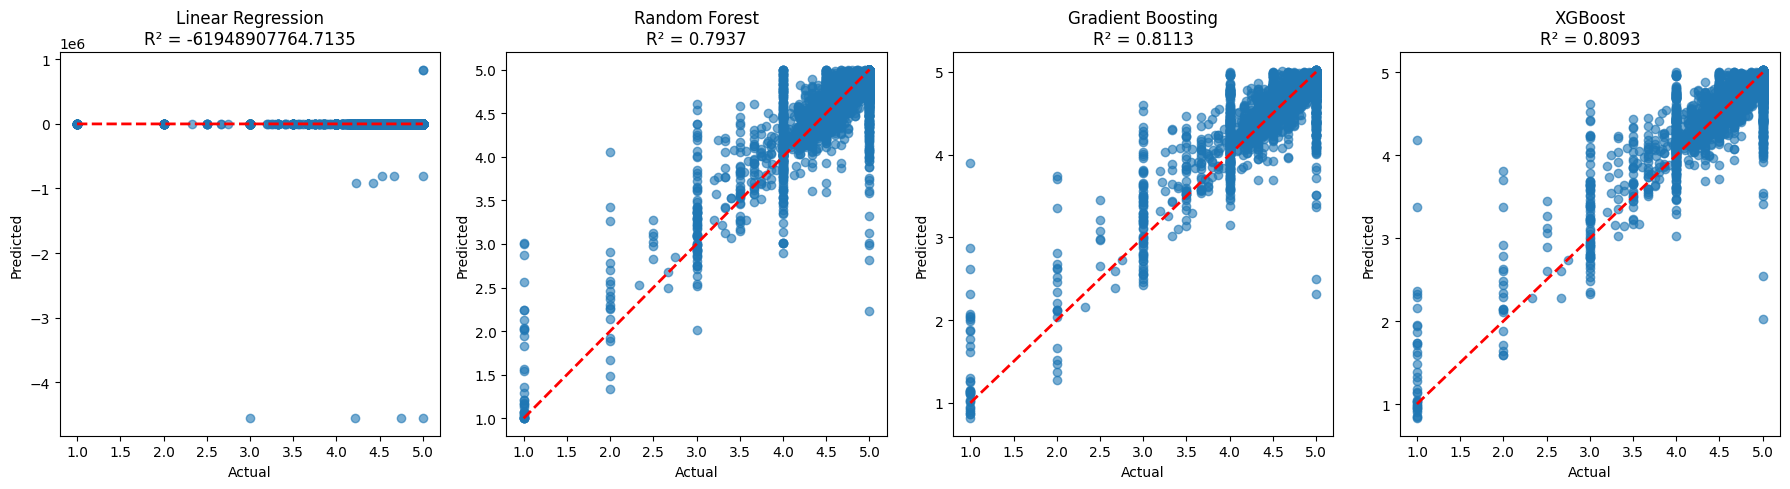

In [49]:
#Plot results
models = {'rf_model': rf_model, 'gb_model': gb_grid_search, 'lr_model': lr_model, 'xgb_model': xgb_grid_search}

# Create predictions dictionary for plotting
predictions = {
    'Linear Regression': models['lr_model'].predict(X_test),
    'Random Forest': models['rf_model'].predict(X_test),
    'Gradient Boosting': models['gb_model'].predict(X_test),
    'XGBoost': models['xgb_model'].predict(X_test)
}

# Plot results
plot_predictions(y_test, predictions)

In [50]:
# Summary
results_df = pd.DataFrame(results).T
print(results_df.sort_values('R2', ascending=False))

                        MAE      RMSE        R2
Gradient Boosting  0.119765  0.218942  0.811288
XGBoost            0.120083  0.220091  0.809302
Random Forest      0.122606  0.228910  0.793713
Linear Regression  0.125852  0.258064  0.737821
